### **Técnicas econométricas aplicadas ao mercado cambial e acionista:**
##            **Projecto de Análise Exploratória de Dados**


           

 O presente trabalho tem o intuito de demonstrar a aplicação de técnicas econométricas no  mercado cambial e acionista, através da linguagem R. O objetivo é apontar retornos provenientes das estratégias de momentum, Reversals e Index Timing, visando o estudo de potenciais resultados positivos e/ou negativos provenientes deste tipo de estratégia de mercado. Buscam-se várias formas de validar a existência de padrões e técnicas que permitam aos investidores vislumbrar de estratégias rentáveis, para investigação de retornos passados, para tanto, o estudo de anomalias fica em posição de conceber estas observações. 

In [ ]:
install.packages("reshape2")
install.packages("data.table")
install.packages("tidyquant")
install.packages("dplyr")
install.packages("quantmod")
install.packages("readxl")
install.packages("ggplot2")
install.packages("tidytable")


In [ ]:
library(readxl) 
library(ggplot2)
library(tidyr)
library(tidytable)
library(dplyr)
library(data.table)
library(reshape2)
library(tidyquant)

###                          **MOMENTUM**

In [ ]:
#Importação dos dados e retorno das estatisticas básicas de cada moeda no periodo de 20 anos.
Dados <- read_excel("DadosFX.xlsx")
Dados <- as.data.table(Dados, FALSE)

summary(Dados)

In [12]:
#Criando um vetor para as moedas
Moedas <- c("Data", "YEN", "EURO", "REAL", "LIBRA", "A_DOLAR", "C_DOLAR",
            "RAND", "M_PESO", "ROUBLE", "LIRA", "S_KRONA", "C_PESO", "N_KRONE",
            "Co_PESO", "A_PESO", "WON")


**PROPOSTA**

A base de dados Foreign exchange market – FX, utiliza uma amostra composta por 16 diferentes moedas e um horizonte temporal de 26/09/1996 à 26/09/2016 (20 anos), sobre os quais se comparam suas rentabilidades e eficiências.

  1- Extraímos 8 preços de cambios. Logo, Calcular a estratégia de Momentum diária, com a média e desvio padrão dos 120 dias anteriores, comparando as moedas selecionadas e analisando quais trazem lucro ou prejuizo no periodo selecionado.
  
  2 -Sugirimos tambem,  traçar uma estratégia atrelada a uma periodicidade anual pois a janela de dados é de 20 anos com todas as moedas. Retrocedendo  para determinar se desejamos manter determinada para o próximo ano. 
  
  Sendo assim a intenção é converter os preços diários para preços anuais ancorada à media de preços anuais. 

In [ ]:
# Selecionamos 8 moedas. Para a visualização dos dados, fomatação de colunas e criação de variável ano.

dt <- read_excel("DadosFX.xlsx")
colnames(dt) <- c("Data", "YEN", "EURO", "REAL", "LIBRA", "A_DOLAR", "C_DOLAR",  "RAND", "M_PESO", "ROUBLE", "LIRA", "S_KRONA", "C_PESO", "N_KRONE",  "Co_PESO", "A_PESO", "WON")
dt$ano <- format(dt$Data, format = "%Y")
nome_colunas <- c("EURO", "REAL", "LIBRA", "A_DOLAR", "C_DOLAR", "M_PESO", "A_PESO", "WON")
dt <- dt %>% select("Data", "ano", nome_colunas) %>% mutate_at(nome_colunas, as.numeric)
head(dt, 10)

A diferença dos logaritmos foi aplicada para todos os mercados (moedas) em todos os dias, um valor essencial para definição o efeito momentum, é dada por: 
 **Retorno t : t / t-1 **


In [ ]:
# Retorno

retorno <- dt %>% mutate_across.(nome_colunas, list(re =  ~ .x/lag(.x) -1))

retorno <- retorno %>% select(Data, ends_with("_re"))


retorno

O momentum pode ser definido como um fenômeno comportamental de séries temporais ou comportamento temporal dos preços (Griné, 2018). O cálculo de momentum para cada dia corresponde à média dos retornos da janela temporal de 120 dias ,pelo desvio padrão do mesmo período:

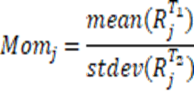

In [ ]:
# Momentum Diário, por moeda.

momentum <- retorno %>% mutate_across.(c("EURO_re", "REAL_re", "LIBRA_re", "A_DOLAR_re",
                                         "C_DOLAR_re", "M_PESO_re", "A_PESO_re", "WON_re"),
                                       list(mom = ~ rollapplyr(.x, 121, mean, fill = NA)/rollapplyr(.x, 121, sd, fill = NA))) %>% 
  select(Data, ends_with("_mom")) %>%
  
  mutate(Media_moedas = rowMeans(.[,2:9]))

momentum

In [ ]:
# Analisando por gráfico

momentum %>% 
  ggplot(aes(x = Data,
             y = Media_moedas)) +
  geom_point() +
  # adicionar reta de ajuste de um modelo linear
  geom_smooth(method = "lm")

O momentum é a diferença entre o preço de fechamento no instante atual em relação aos períodos anteriores, sendo positivo com intensa valorização quanto maior for a inclinação da linha que o representa e com inclinação contrária representando desvalorização. Leva-se em conta nesta analise que quando o efeito momentum está no fundo e começa a subir houve compra, e ao contrário venda.
Ao observar as médias diárias do efeito momentum, das moedas selecionadas, podemos verificar que a reta de ajuste para modelo linear como um indicador de tendência, destaca alguns pontos de início e encerramento de operações devido ao nível de força e momentos em que o indicador não acompanha o preço. Visualmente este fenômeno é observado como sendo mais forte em períodos de manutenção inferiores a 12 meses, após o período é possível identificar regiões de compra e venda.


O calculo da médias de todas as moedas nos permite analisar o efeito momentum de todas as moedas selecionadas num horizonte temporal.

**PESOS**

In [ ]:
momentum1 <- retorno %>% mutate_across.(c("EURO_re", "REAL_re", "LIBRA_re", "A_DOLAR_re",
                                         "C_DOLAR_re", "M_PESO_re", "A_PESO_re", "WON_re"),
                                       list(mom = ~ rollapplyr(.x, 121, mean, fill = NA)/rollapplyr(.x, 121, sd, fill = NA))) %>% 
  select(Data, ends_with("_mom"))

momentum1

In [ ]:
# Peso das moedas - Peso por dia das moedas Coluna 2 - coluna 9

peso <- momentum1 %>% mutate(media = rowMeans(.[,2:9], na.rm = TRUE)) 

colnames(peso) <- c("Data", nome_colunas, "media")

peso <- peso %>% mutate_across.(nome_colunas, list(pes = ~ . - media)) %>% select(Data, ends_with("_pes"))

peso

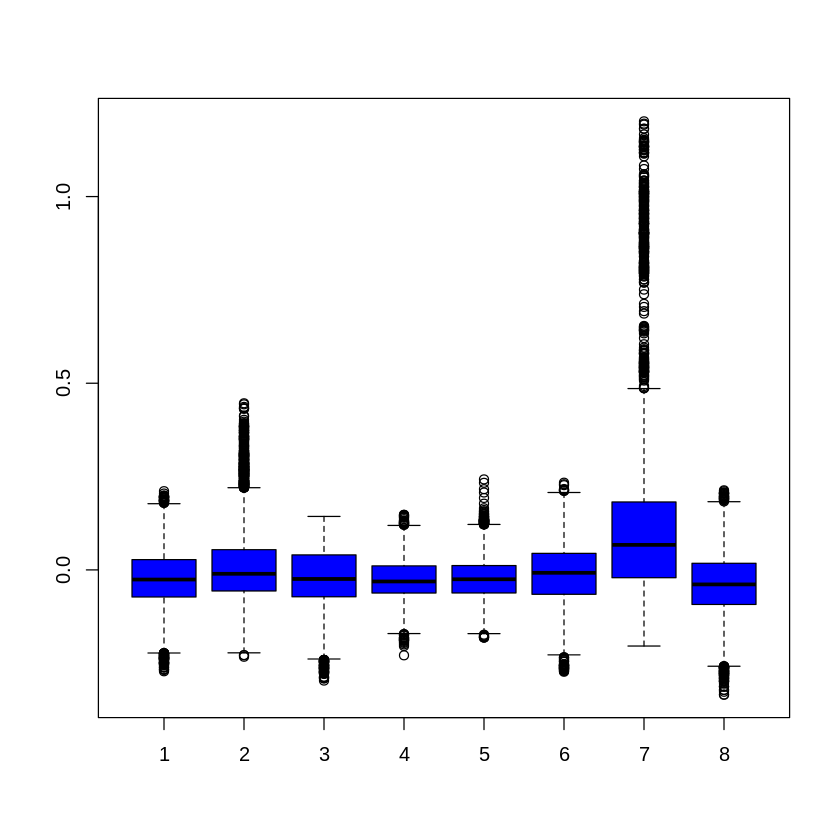

In [20]:
boxplot(peso$EURO_pes,peso$REAL_pes,peso$LIBRA_pes,peso$A_DOLAR_pes,peso$C_DOLAR_pes,peso$M_PESO_pes,peso$A_PESO_pes,peso$WON_pes, col="blue")


**Aplicação da estratégia**

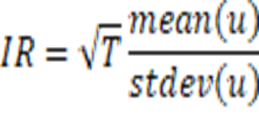

Com os dados cambiais disponíveis testaremos a estratégias para diferentes janelas temporais. 

In [ ]:
estrategia_final <- data.table(data = peso[,1],
                               s = 1,
                               estrategia = rowSums(peso[,2:9]*momentum[,2:9]))

estrategia_final <- na.omit(estrategia_final)

for (i in seq_along(estrategia_final$s)) {
  
  if (i == 1) {
    
    estrategia_final$s[[i]] <- (1 * (1 + estrategia_final$estrategia[[i]]))
  }
  
  if (i > 1) {
    
    # Consequent values [i] depend on the lagged value [i-1]
    estrategia_final$s[[i]] <- (estrategia_final$s[[i-1]] * (1 + estrategia_final$estrategia[[i]]))
    
  } 
}
estrategia_final

Utilizaremos o indicador Information Ratio como medida de retorno, apontando a diferença média entre as rentabilidades e avaliar as estratégias quantitativas.

No id variables; using all as measure variables



variable,value
<fct>,<dbl>
EURO_re_mom,NA
EURO_re_mom,NA
EURO_re_mom,NA
EURO_re_mom,NA
EURO_re_mom,NA
EURO_re_mom,NA
EURO_re_mom,NA
EURO_re_mom,NA
EURO_re_mom,NA


ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'ano' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8. paste(capture.output(print(obj

variable,value
<fct>,<dbl>
EURO_re_mom,NA
EURO_re_mom,NA
EURO_re_mom,NA
EURO_re_mom,NA
EURO_re_mom,NA
EURO_re_mom,NA
EURO_re_mom,NA
EURO_re_mom,NA
EURO_re_mom,NA


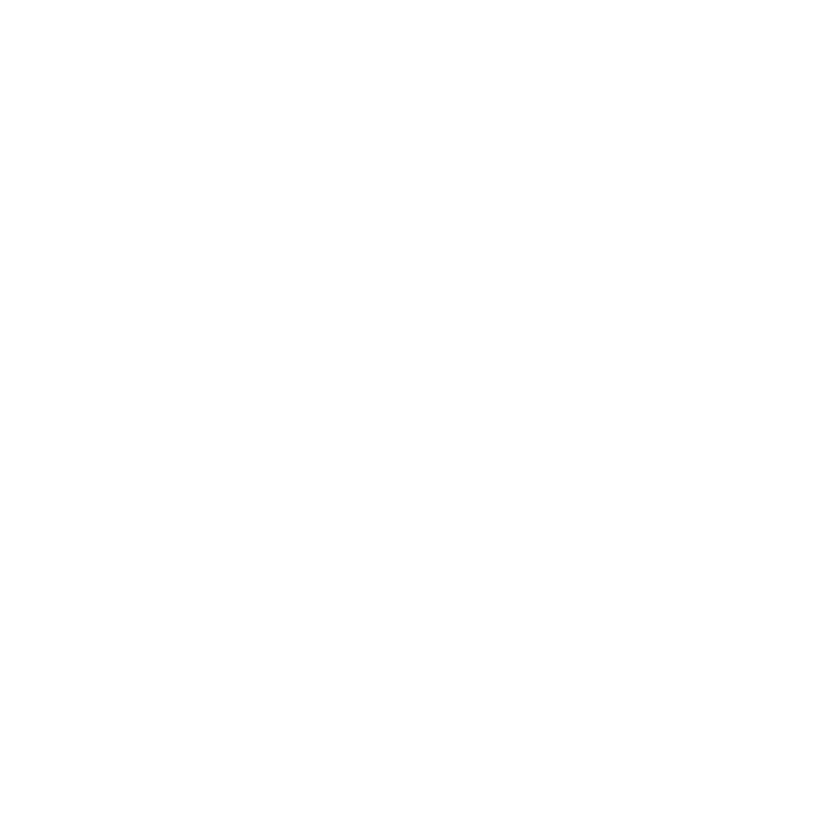

In [22]:
mom <- momentum1 %>% select(setdiff(names(momentum1), c("Data", "mes")))

graph <- mom %>% melt(key = year)

graph

ggplot(graph, aes(x= ano, y= value)) +
    geom_line(aes(color=variable), group=1)

    graph

###                          **REVERSALS**

In [ ]:
#Para uma visualização mais detalhada , primeiramente vamos importar os dados de ações da para o R:

dt_r <- read_excel("BrasilEquities.xlsx") 

dt_r <- dt_r %>% select(Date, S2, S4, S7, S13, S18, S22)

dt_r

Nesta Secção são apresentados os resultados da Decomposição da Cross-Sectional
Volatility através de representações gráficas, sendo que, as mesmas, serão apresentadas
sob forma de média móvel das últimas 12 observações, conforme realizado por
Menchero e Morozov (2010), esta forma de apresentação permite suavizar a
representação, facilitando a análise e conclusões adjacentes. De notar que esta
suavização da representação, inibe a ilustração de variações abruptas de volatilidade,
dando primazia à tendência verificada a cada momento temporal.

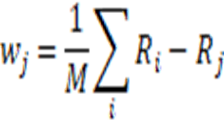

In [ ]:
mediaS2 <- mean(dt_r$S2, na.rm = TRUE)

estrategiaS2 <- dt_r %>% select(Date, S2) %>% mutate(s2_r = (1/mediaS2)*(lag(S2) - S2))

estrategiaS2

In [ ]:
mediaS4 <- mean(dt_r$S4, na.rm = TRUE)

estrategiaS4 <- dt_r %>% select(Date, S4) %>% mutate(s4_r = (1/mediaS4)*(lag(S4) - S4))

estrategiaS4

In [ ]:
mediaS7 <- mean(dt_r$S7, na.rm = TRUE)

estrategiaS7 <- dt_r %>% select(Date, S7) %>% mutate(s7_r = (1/mediaS2)*(lag(S7) - S7))

estrategiaS7

In [ ]:
mediaS13 <- mean(dt_r$S13, na.rm = TRUE)

estrategiaS13 <- dt_r %>% select(Date, S13) %>% mutate(s13_r = (1/mediaS13)*(lag(S13) - S13))

estrategiaS13

In [ ]:
mediaS18 <- mean(dt_r$S18, na.rm = TRUE)

estrategiaS18 <- dt_r %>% select(Date, S18) %>% mutate(s18_r = (1/mediaS18)*(lag(S18) - S18))

estrategiaS18

In [ ]:
mediaS22 <- mean(dt_r$S22, na.rm = TRUE)

estrategiaS22 <- dt_r %>% select(Date, S22) %>% mutate(s22_r = (1/mediaS22)*(lag(S22) - S22))

estrategiaS22

In [33]:
reversals <-
dt_r %>% 
  left_join(estrategiaS2, by = "Date") %>%
  left_join(estrategiaS4, by = "Date") %>%
  left_join(estrategiaS7, by = "Date") %>%
  left_join(estrategiaS13, by = "Date") %>%
  left_join(estrategiaS18, by = "Date") %>%
  left_join(estrategiaS22, by = "Date") %>%
 
  na.omit()

reversals %>% 
   select(Date, contains("_r")) %>% 
  head()

Date,s2_r,s4_r,s7_r,s13_r,s18_r,s22_r
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1996-11-08,0.001196341,-0.0006650644,0,0.002868750,0,0
1996-11-11,-0.003589022,0.0013301288,0,-0.010901252,0,0
1996-11-12,0.003589022,-0.0006650644,0,-0.005163751,0,0
1996-11-13,-0.001196341,0.0006650644,0,-0.008032501,0,0
1996-11-14,0.001196341,0.0006650644,0,0.005163751,0,0
1996-11-15,0.000000000,0.0000000000,0,0.000000000,0,0


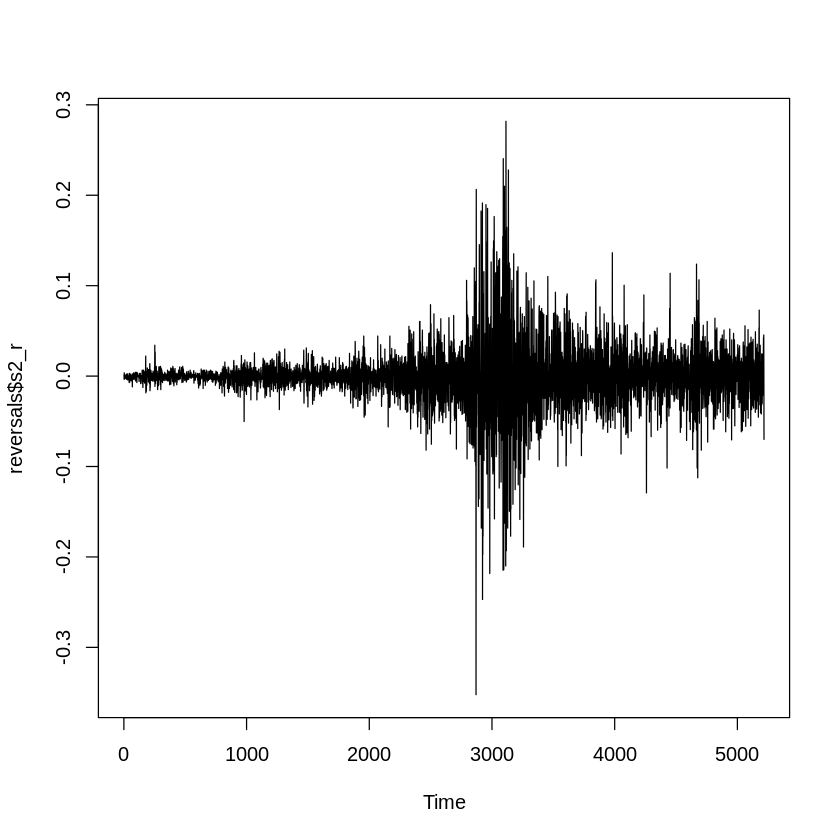

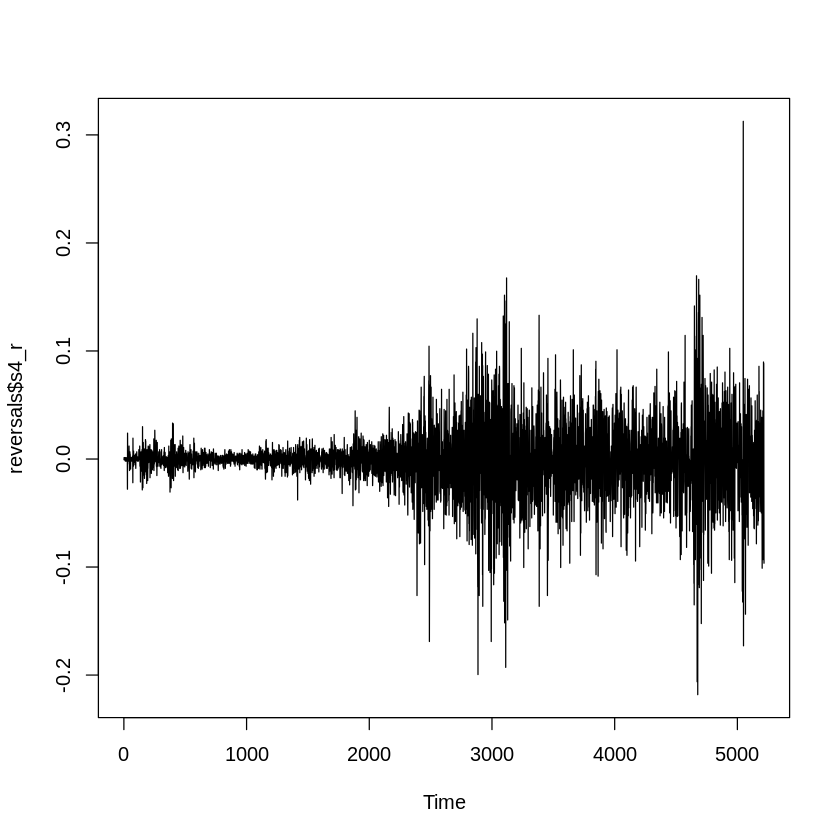

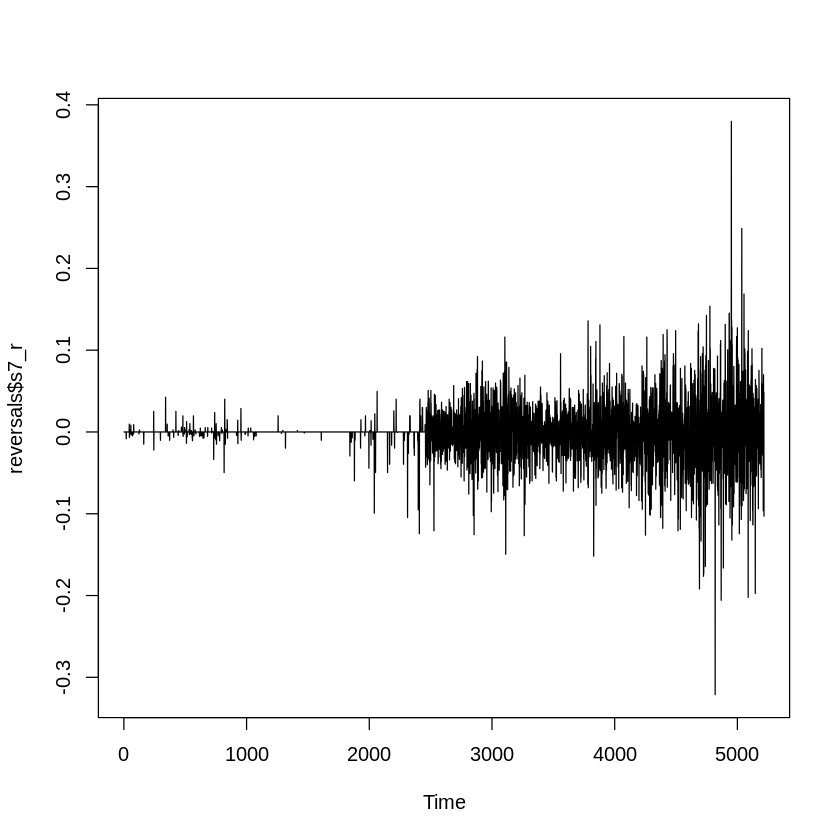

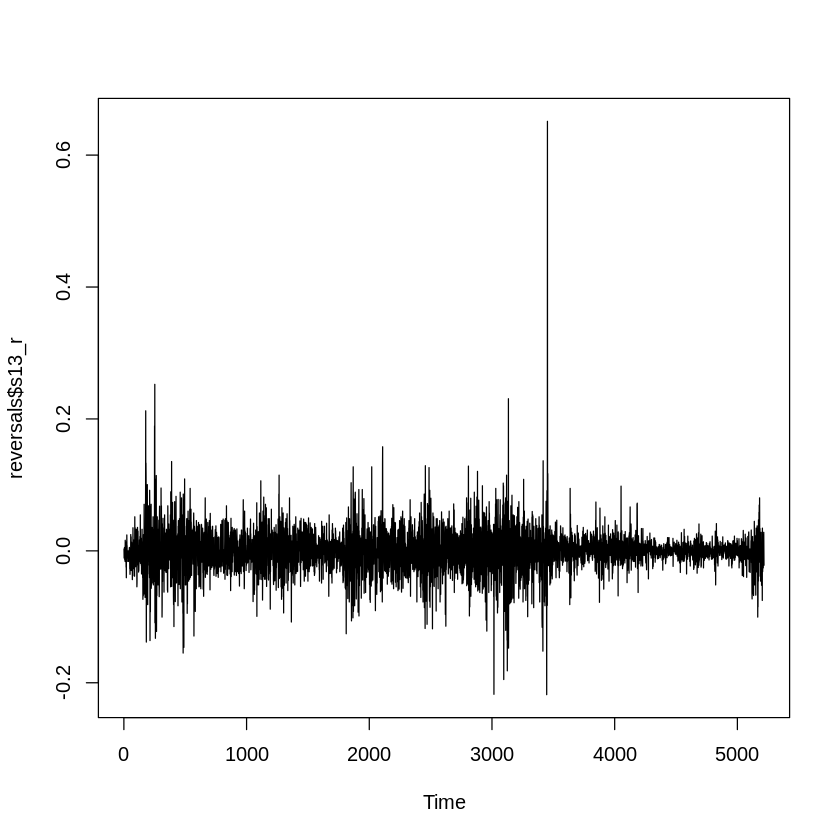

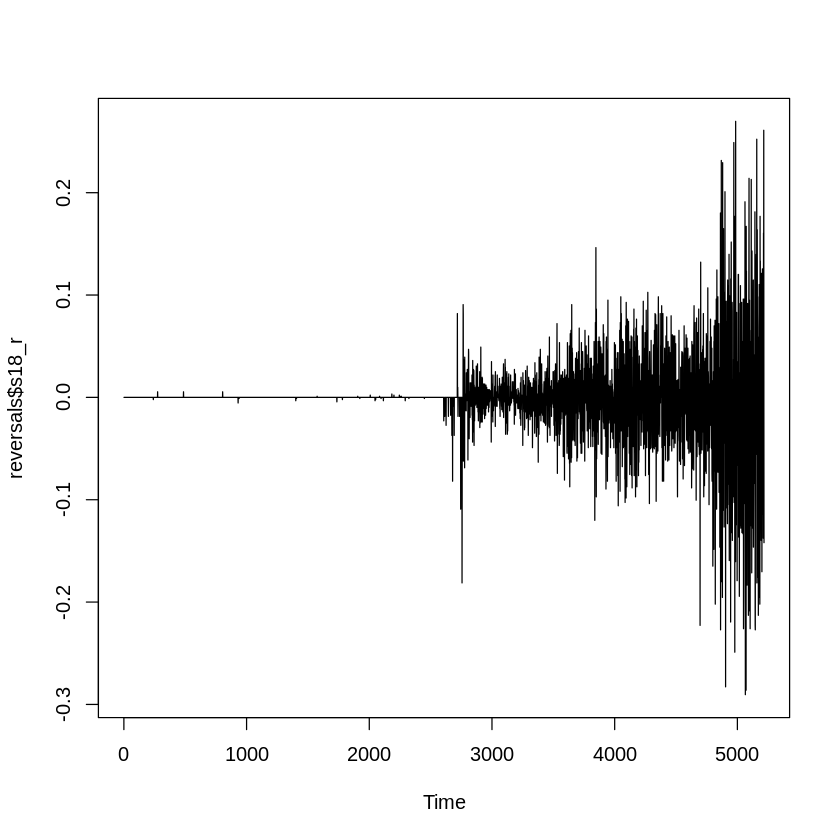

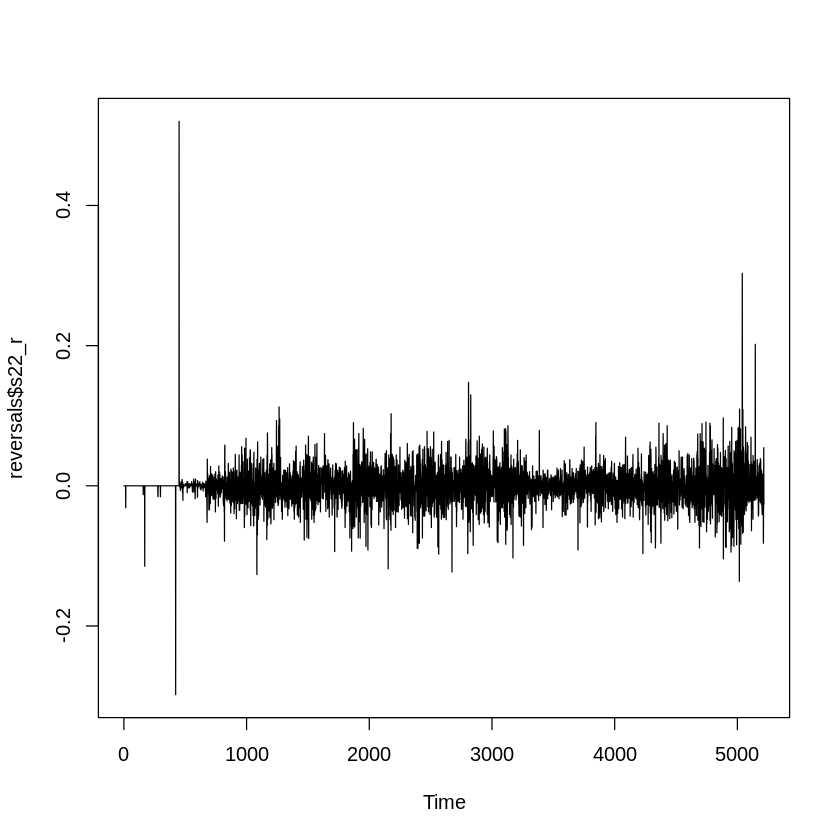

In [51]:
plot.ts(reversals$s2_r)
plot.ts(reversals$s4_r)
plot.ts(reversals$s7_r)
plot.ts(reversals$s13_r)
plot.ts(reversals$s18_r)
plot.ts(reversals$s22_r)

Nesta Secção são apresentados os resultados da Cross-Sectional através de representações gráficas de plotagem TS que fornece lotes de séries de tempo univariadas que permite apontar o desenvolvimento de um modelo de previsão ou um exame visual dos dados originais, a tendência dos dados, a sazonalidade e a tendência de variações abruptas de volatilidade.